<a href="https://colab.research.google.com/github/Chienlovecode/Apple_stocks_predict/blob/main/Apple_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

#Define start day to fetch the dataset from the yahoo finance library

In [11]:
# Tạo Spark session
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

# Thiết lập thời gian tải dữ liệu
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [12]:
# Hàm tải dữ liệu từ Yahoo Finance
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [13]:
# Bước 1: Tải dữ liệu từ Yahoo Finance
df = load_data("AAPL")

# ✅ Xử lý tên cột: xoá multi-level index
df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

# ✅ In lại tên cột để kiểm tra
print(df.columns)

# Bước 2: Tạo Spark DataFrame từ Pandas
df_spark = spark.createDataFrame(df)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


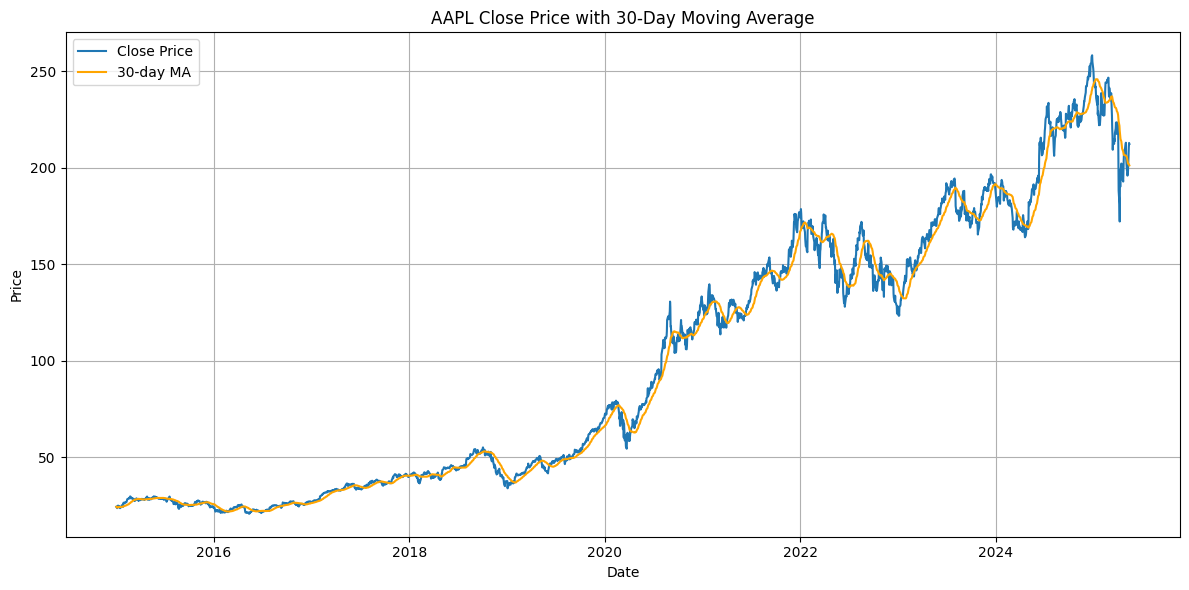

In [14]:
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

# Đảm bảo cột 'Date' là kiểu ngày
df_spark = df_spark.withColumn("Date", to_date(col("Date")))

# Giữ lại các cột cần thiết
df_spark = df_spark.select("Date", "Close")

# Tính MA 30 ngày
windowSpec = Window.orderBy("Date").rowsBetween(-29, 0)
df_spark = df_spark.withColumn("MA_30", avg("Close").over(windowSpec))

# Sắp xếp theo ngày
df_spark = df_spark.orderBy("Date")

# Chuyển về Pandas để vẽ
df_plot = df_spark.toPandas()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
plt.plot(df_plot["Date"], df_plot["MA_30"], label="30-day MA", color="orange")
plt.title("AAPL Close Price with 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from pyspark.sql.functions import lag, when, lit
from pyspark.sql.window import Window

# Thêm cột change = Close - Close của ngày trước
windowSpec_lag = Window.orderBy("Date")
df_spark = df_spark.withColumn("prev_Close", lag("Close").over(windowSpec_lag))
df_spark = df_spark.withColumn("change", col("Close") - col("prev_Close"))

# Tính gain và loss
df_spark = df_spark.withColumn("gain", when(col("change") > 0, col("change")).otherwise(lit(0.0)))
df_spark = df_spark.withColumn("loss", when(col("change") < 0, -col("change")).otherwise(lit(0.0)))

# Cửa sổ 14 ngày để tính trung bình gain và loss
windowSpec_rsi = Window.orderBy("Date").rowsBetween(-13, 0)

df_spark = df_spark.withColumn("avg_gain", avg("gain").over(windowSpec_rsi))
df_spark = df_spark.withColumn("avg_loss", avg("loss").over(windowSpec_rsi))

# Tính RSI
df_spark = df_spark.withColumn(
    "RSI_14",
    when(col("avg_loss") == 0, lit(100))
    .otherwise(100 - (100 / (1 + col("avg_gain") / col("avg_loss"))))
)


In [16]:
df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").show(20)


+----------+------------------+------------------+------------------+
|      Date|             Close|             MA_30|            RSI_14|
+----------+------------------+------------------+------------------+
|2015-01-02|24.288583755493164|24.288583755493164|             100.0|
|2015-01-05|23.604331970214844|23.946457862854004|               0.0|
|2015-01-06| 23.60655975341797|23.833158493041992|0.3245228708048842|
|2015-01-07| 23.93756866455078| 23.85926103591919| 32.75090588369822|
|2015-01-08|24.857309341430664|24.058870697021483| 64.67884127262309|
|2015-01-09|24.883970260620117| 24.19638729095459| 65.15834599143005|
|2015-01-12|24.270811080932617| 24.20701926095145|49.655173945094276|
|2015-01-13|24.486305236816406| 24.24193000793457| 53.54016844512351|
|2015-01-14| 24.39299201965332| 24.25871467590332|51.808964851753444|
|2015-01-15|    23.73095703125| 24.20593891143799|42.141435189291855|
|2015-01-16|23.546567916870117|    24.14599609375| 40.05948517725458|
|2015-01-20| 24.1530

In [17]:
df_plot = df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").toPandas()


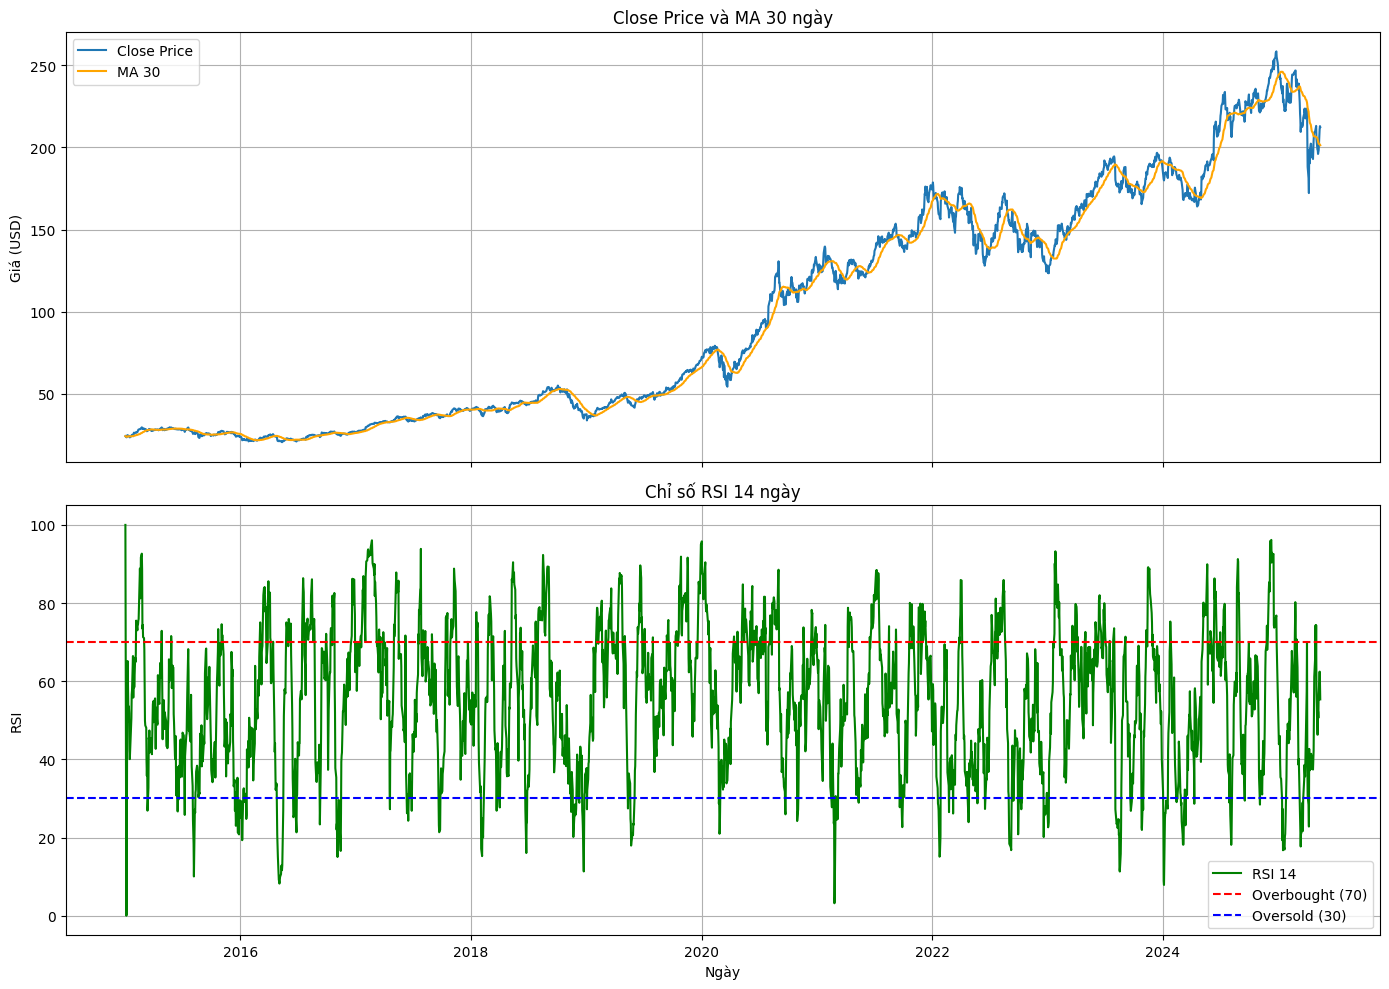

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ giá Close và MA_30
ax1.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
ax1.plot(df_plot["Date"], df_plot["MA_30"], label="MA 30", color="orange")
ax1.set_title("Close Price và MA 30 ngày")
ax1.set_ylabel("Giá (USD)")
ax1.legend()
ax1.grid(True)

# Biểu đồ RSI 14 ngày
ax2.plot(df_plot["Date"], df_plot["RSI_14"], label="RSI 14", color="green")
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
ax2.set_title("Chỉ số RSI 14 ngày")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Ngày")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



# Training the model


In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # Import the Sequential model
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import necessary layers


# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Keras model before compiling
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Now you can proceed with compiling and training the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - MAE: 0.0702 - loss: 0.0132 - val_MAE: 0.0428 - val_loss: 0.0026
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - MAE: 0.0208 - loss: 0.0011 - val_MAE: 0.0512 - val_loss: 0.0034
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - MAE: 0.0192 - loss: 9.1568e-04 - val_MAE: 0.0265 - val_loss: 0.0012
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - MAE: 0.0182 - loss: 8.5679e-04 - val_MAE: 0.0297 - val_loss: 0.0014
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - MAE: 0.0183 - loss: 8.4262e-04 - val_MAE: 0.0236 - val_loss: 9.4021e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - MAE: 0.0181 - loss: 8.0823e-04 - val_MAE: 0.0481 - val_loss: 0.0031
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - MAE: 0.0172 - loss: 6.9565e-04 - val_MAE: 0.0444 - val_loss: 0.0027
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - MAE: 0.0159 - loss: 6.1506e-04 - val_MAE: 0.0386 - val_loss: 0.0022
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━

In [22]:
model.save('keras_model.h5')

In [25]:
# Assuming you want to check the shape and values of 'x_test':
print(x_test.shape)
print(x_test)

# OR, if you want to check 'y_test':
print(y_test.shape)
print(y_test)

# Make predictions using the model
predictions = model.predict(x_test) # Added this line

# OR, if you want to check the predictions made by the model:
print(predictions.shape)  # Assuming 'predictions' is the variable holding model predictions
print(predictions)

(510, 60, 1)
[[[0.54318686]
  [0.55531159]
  [0.54397564]
  ...
  [0.61879677]
  [0.6184226 ]
  [0.61405578]]

 [[0.55531159]
  [0.54397564]
  [0.53961581]
  ...
  [0.6184226 ]
  [0.61405578]
  [0.60952286]]

 [[0.54397564]
  [0.53961581]
  [0.54115453]
  ...
  [0.61405578]
  [0.60952286]
  [0.60261958]]

 ...

 [[0.92772643]
  [0.94062229]
  [0.94007624]
  ...
  [0.73752306]
  [0.74273186]
  [0.74710048]]

 [[0.94062229]
  [0.94007624]
  [0.94175642]
  ...
  [0.74273186]
  [0.74710048]
  [0.79976096]]

 [[0.94007624]
  [0.94175642]
  [0.94578905]
  ...
  [0.74710048]
  [0.79976096]
  [0.80876204]]]
(510,)
[0.60952286 0.60261958 0.63497403 0.63468284 0.62748844 0.63493244
 0.63572256 0.63180809 0.62972589 0.62972589 0.63230779 0.64213583
 0.64259389 0.63859604 0.62760204 0.628768   0.63355706 0.6437182
 0.65150569 0.65129743 0.66312436 0.66670574 0.66100064 0.65945967
 0.65367119 0.66512338 0.66674752 0.67853267 0.67653385 0.67919906
 0.68777777 0.68323862 0.68361331 0.67924071 0.69190

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Extract the training data for 'Close' prices and inverse transform to get original values
train_close = scaler.inverse_transform(y_train.reshape(-1, 1)) #Added this line to get train_close

# Now you can proceed with compiling and training the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

In [27]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Extract the training data for 'Close' prices and inverse transform to get original values
train_close = scaler.inverse_transform(y_train.reshape(-1, 1)) #Added this line to get train_close

# Extract the testing data for 'Close' prices and inverse transform to get original values
test_close = scaler.inverse_transform(y_test.reshape(-1, 1)) # Added this line to get test_close

# Now you can proceed with compiling and training the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

#Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Extract the training data for 'Close' prices and inverse transform to get original values
train_close = scaler.inverse_transform(y_train.reshape(-1, 1)) #Added this line to get train_close

# Extract the testing data for 'Close' prices and inverse transform to get original values
test_close = scaler.inverse_transform(y_test.reshape(-1, 1)) # Added this line to get test_close

# Get the last 100 days of the training data
past_100_days = train_close[-100:] # Assuming train_close is a NumPy array

# Assuming test_close is your test_df
test_df = test_close

# Now you can proceed with compiling and training the model
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

# Concatenate past_100_days and test_df
final_df = np.concatenate([past_100_days, test_df])

In [29]:
import pandas as pd # Import pandas

# ... (Your existing code to create final_df) ...

final_df = pd.DataFrame(final_df) # Convert final_df to a Pandas DataFrame
final_df.head() # Now you can call head()

,0
0,139.137650
1,140.825790
2,140.342087
3,142.642273
4,143.609772


In [30]:
input_data = scaler.fit_transform(final_df)
input_data

array([[1.16438981e-01],
       [1.28946006e-01],
       [1.25362363e-01],
       [1.42403882e-01],
       [1.49571845e-01],
       [1.33041984e-01],
       [8.39649644e-02],
       [6.94100635e-02],
       [5.37581385e-02],
       [5.32460281e-02],
       [7.62852303e-02],
       [5.27341438e-02],
       [5.00277591e-02],
       [3.66433639e-02],
       [7.46030664e-03],
       [3.35714364e-02],
       [3.59118261e-02],
       [3.65599340e-04],
       [9.80086593e-03],
       [0.00000000e+00],
       [3.36444658e-02],
       [3.75209606e-02],
       [4.17631113e-02],
       [6.19497569e-02],
       [6.13646171e-02],
       [7.12385124e-02],
       [7.98692118e-02],
       [7.45298109e-02],
       [7.49687788e-02],
       [9.39850317e-02],
       [1.17682516e-01],
       [1.28068409e-01],
       [1.23168089e-01],
       [1.38527783e-01],
       [1.52935834e-01],
       [1.31506105e-01],
       [1.40941146e-01],
       [1.49279049e-01],
       [1.88701601e-01],
       [2.15617242e-01],


In [31]:
input_data.shape

(610, 1)

# Testing the model

In [32]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [33]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(510, 100, 1)
(510,)


# Making prediction and plotting the graph of predicted vs actual values

In [35]:
# Making predictions
y_pred = model.predict(x_test)
y_pred.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


(510, 1)

In [36]:
y_pred.shape

(510, 1)

In [37]:
y_test

array([0.31220341, 0.30004378, 0.35703376, 0.35652086, 0.34384844,
       0.3569605 , 0.35835224, 0.35145718, 0.34778954, 0.34778954,
       0.35233738, 0.36964874, 0.37045557, 0.36341366, 0.34404854,
       0.34610229, 0.35453787, 0.37243596, 0.38615305, 0.38578621,
       0.40661848, 0.41292682, 0.4028777 , 0.4001634 , 0.38996743,
       0.4101396 , 0.41300041, 0.43375909, 0.4302383 , 0.43493287,
       0.45004363, 0.44204827, 0.44270824, 0.43500624, 0.45730554,
       0.4549582 , 0.44461571, 0.46508102, 0.47381019, 0.47630393,
       0.50843281, 0.49735653, 0.48906757, 0.49258836, 0.48429952,
       0.46911539, 0.46522776, 0.47762445, 0.48327247, 0.48437289,
       0.50857932, 0.50667219, 0.51672176, 0.50227109, 0.49354215,
       0.49948365, 0.50586536, 0.51232044, 0.50293118, 0.52207642,
       0.52662426, 0.52046254, 0.49823661, 0.4878939 , 0.42055591,
       0.39752281, 0.40449136, 0.39268128, 0.39106773, 0.39150851,
       0.40377497, 0.38901104, 0.38254726, 0.36367017, 0.36726

In [38]:
y_pred

array([[0.31980127],
       [0.32126024],
       [0.318404  ],
       [0.32507166],
       [0.3346997 ],
       [0.3414144 ],
       [0.34809297],
       [0.35371873],
       [0.35642484],
       [0.35655683],
       [0.35546854],
       [0.35489216],
       [0.35801485],
       [0.36237043],
       [0.36509636],
       [0.36280465],
       [0.35909906],
       [0.35707515],
       [0.35967863],
       [0.36658266],
       [0.37407038],
       [0.38452676],
       [0.3955428 ],
       [0.4026682 ],
       [0.40610665],
       [0.40515283],
       [0.40636033],
       [0.40879712],
       [0.4154367 ],
       [0.4219451 ],
       [0.42808267],
       [0.43586588],
       [0.44121143],
       [0.44455054],
       [0.44475642],
       [0.44797996],
       [0.4513766 ],
       [0.45211506],
       [0.45565754],
       [0.46146458],
       [0.46763888],
       [0.47929934],
       [0.4887473 ],
       [0.49366027],
       [0.49627167],
       [0.4955803 ],
       [0.4904617 ],
       [0.483

In [39]:
scaler.scale_

array([0.00740876])

In [40]:
scale_factor = 1/0.00985902
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

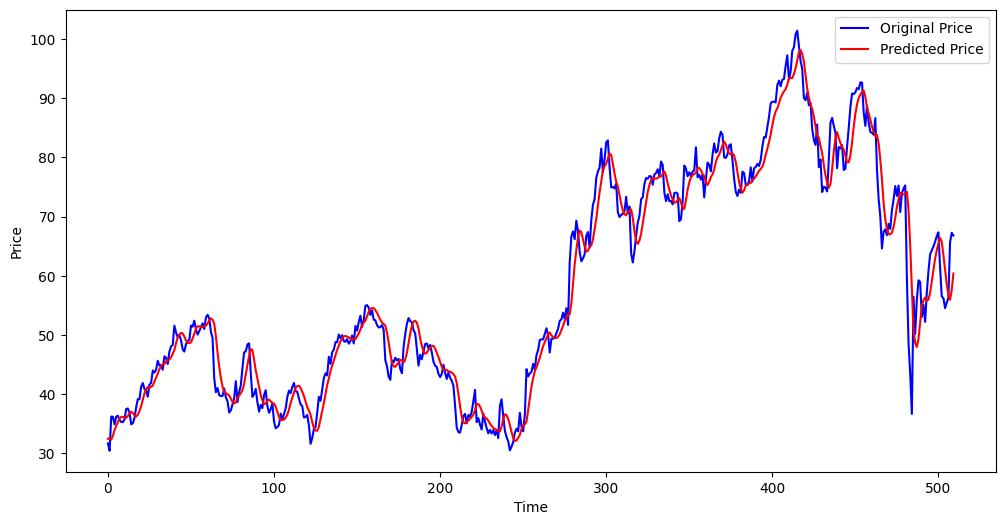

In [41]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model evaluation

In [43]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  57.50838692368611
